### Overview of the FUNSD Dataset

TheThe FUNSD (Form Understanding in Noisy Scanned Documents) dataset is a publicly available dataset specifically designed for **form understanding in noisy scanned documents**. Its primary purpose is to advance research in information extraction from visually rich documents, enabling models to accurately parse and understand the content of scanned forms.

#### Dataset Structure

Each document within the FUNSD dataset comprises several key components, providing a rich source of information for training and evaluating models:

1.  **Image Files**: Each entry includes a scanned image of a form, representing the visual layout and content of the document. These images often contain noise, distortions, and varying quality, mimicking real-world scanned documents.

2.  **JSON Annotation Files**: Alongside each image, there's a corresponding JSON file that provides detailed annotations. These annotations are crucial for understanding the document's structure and content programmatically.

    *   **Bounding Boxes**: For each significant textual element on the form, a bounding box is provided. These boxes define the precise location (coordinates) of text segments within the image. This is fundamental for visual information extraction.
    *   **Text Content**: The actual text contained within each bounding box is also provided. This allows models to learn the semantic meaning associated with the visual elements.
    *   **Semantic Labels**: Each textual element is assigned a semantic label, categorizing its role within the form. Common labels include:
        *   **'question'**: Identifies fields that pose a question (e.g., 'Name:', 'Date of Birth:').
        *   **'answer'**: Identifies fields that contain responses to questions (e.g., 'John Doe', '01/01/1990').
        *   **'header'**: Denotes titles or section headers in the document.
        *   **'other'**: For text that doesn't fall into the primary categories.
    *   **Linking Information**: A critical feature of FUNSD is the linking information. This data explicitly connects related entities, such as linking a 'question' bounding box to its corresponding 'answer' bounding box. This is vital for understanding relationships between different parts of the form and reconstructing the underlying structured data.

#### Role in Contextual Document Understanding and Form Parsing

The FUNSD dataset plays a pivotal role in contextual document understanding tasks, especially in **form parsing**, due to its detailed annotations:

*   **Information Extraction**: By providing bounding boxes, text content, and semantic labels, FUNSD enables models to not only locate text but also understand what that text represents in the context of a form. This moves beyond simple Optical Character Recognition (OCR) to true semantic understanding.
*   **Relational Understanding**: The linking information is particularly valuable for form parsing. It allows models to establish relationships between fields (e.g., pairing a question with its answer), which is essential for converting unstructured document data into a structured format (like a table or a database record).
*   **Robustness to Noise**: The inclusion of 'noisy scanned documents' helps in developing robust models that can handle real-world challenges such as varying scan quality, handwriting, stamps, and other visual distractions.
*   **End-to-End Solutions**: FUNSD facilitates the development of end-to-end systems that can take a raw image of a form and output structured data, including the values of specific fields and their relationships.

In essence, FUNSD provides the necessary ground truth for training machine learning models to effectively read, understand, and extract structured information from complex, visually rich forms, a critical capability for automating business processes and digitalizing paper-based information.

In [ ]:
import os
import json
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Define the base path to your FUNSD dataset
# IMPORTANT: Replace '/path/to/your/funsd_dataset' with the actual path where you extracted the dataset.
dataset_path = '/content/funsd'

# Define paths for training and testing data
train_images_path = os.path.join(dataset_path, 'training_data', 'images')
train_annotations_path = os.path.join(dataset_path, 'training_data', 'annotations')
test_images_path = os.path.join(dataset_path, 'testing_data', 'images')
test_annotations_path = os.path.join(dataset_path, 'testing_data', 'annotations')

print(f"Dataset base path: {dataset_path}")
print(f"Training images path: {train_images_path}")
print(f"Training annotations path: {train_annotations_path}")
print(f"Testing images path: {test_images_path}")
print(f"Testing annotations path: {test_annotations_path}")

Dataset base path: /content/funsd
Training images path: /content/funsd/training_data/images
Training annotations path: /content/funsd/training_data/annotations
Testing images path: /content/funsd/testing_data/images
Testing annotations path: /content/funsd/testing_data/annotations


In [ ]:
def parse_funsd_json(json_path):
    """
    Parses a FUNSD dataset JSON annotation file.

    Args:
        json_path (str): The path to the JSON annotation file.

    Returns:
        dict: A dictionary containing:
            - 'words': A list of dictionaries, each with 'box', 'text', 'label', and 'id'.
            - 'relations': A list of dictionaries, each with 'head', 'tail', and 'type'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = []
    for form_entity in data['form']:
        for word_entity in form_entity['words']:
            # The FUNSD dataset's bounding boxes are [x_min, y_min, x_max, y_max]
            # We'll keep them as is for now.
            words.append({
                'box': word_entity['box'],
                'text': word_entity['text'],
                'label': form_entity['label'], # Label is at the form entity level
                'id': word_entity['id']
            })

    relations = data['relations']

    return {'words': words, 'relations': relations}


def load_image(image_path):
    """
    Loads an image from the given path.

    Args:
        image_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image.
    """
    return Image.open(image_path).convert('RGB')

print("Functions `parse_funsd_json` and `load_image` have been defined.")

Functions `parse_funsd_json` and `load_image` have been defined.


In [ ]:
def visualize_document_annotations(image_path, annotation_data):
    """
    Visualizes a document image with its bounding boxes, text, labels, and relations.

    Args:
        image_path (str): Path to the image file.
        annotation_data (dict): Dictionary containing 'words' and 'relations' from parse_funsd_json.
    """
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Assign distinct colors for different labels
    label_colors = {
        'question': (255, 0, 0),    # Red
        'answer': (0, 0, 255),      # Blue
        'header': (0, 128, 0),      # Green
        'other': (255, 165, 0),     # Orange
        'total': (128, 0, 128),     # Purple (if 'total' exists)
    }
    default_color = (0, 0, 0) # Black for unknown labels

    # Try to load a font, fall back to default if not available
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    # Create a mapping from word ID to its bounding box and center for easy relation drawing
    word_id_map = {}
    for word in annotation_data['words']:
        box = word['box']
        word_id_map[word['id']] = {
            'box': box,
            'center': ((box[0] + box[2]) // 2, (box[1] + box[3]) // 2)
        }

        # Draw bounding boxes and text
        color = label_colors.get(word['label'], default_color)
        draw.rectangle(word['box'], outline=color, width=2)
        # Draw text label slightly above or next to the box
        draw.text((word['box'][0] + 5, word['box'][1] - 15), f"{word['text']} ({word['label']})", fill=color, font=font)

    # Draw relations
    for relation in annotation_data['relations']:
        head_id = relation['head']
        tail_id = relation['tail']

        if head_id in word_id_map and tail_id in word_id_map:
            head_center = word_id_map[head_id]['center']
            tail_center = word_id_map[tail_id]['center']
            draw.line([head_center, tail_center], fill=(255, 0, 255), width=2) # Magenta for relations
            # Draw an arrow head (simple triangle)
            # Calculate angle of line
            angle = np.arctan2(tail_center[1] - head_center[1], tail_center[0] - head_center[0])
            # Length of arrow head lines
            arrow_length = 10
            # Draw two lines for the arrow head
            draw.line([tail_center, (tail_center[0] - arrow_length * np.cos(angle - np.pi/6), tail_center[1] - arrow_length * np.sin(angle - np.pi/6))], fill=(255, 0, 255), width=2)
            draw.line([tail_center, (tail_center[0] - arrow_length * np.cos(angle + np.pi/6), tail_center[1] - arrow_length * np.sin(angle + np.pi/6))], fill=(255, 0, 255), width=2)

    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Document: {os.path.basename(image_path)}")
    plt.show()

print("Function `visualize_document_annotations` has been defined.")

Function `visualize_document_annotations` has been defined.


Visualizing sample document: 00866042.png


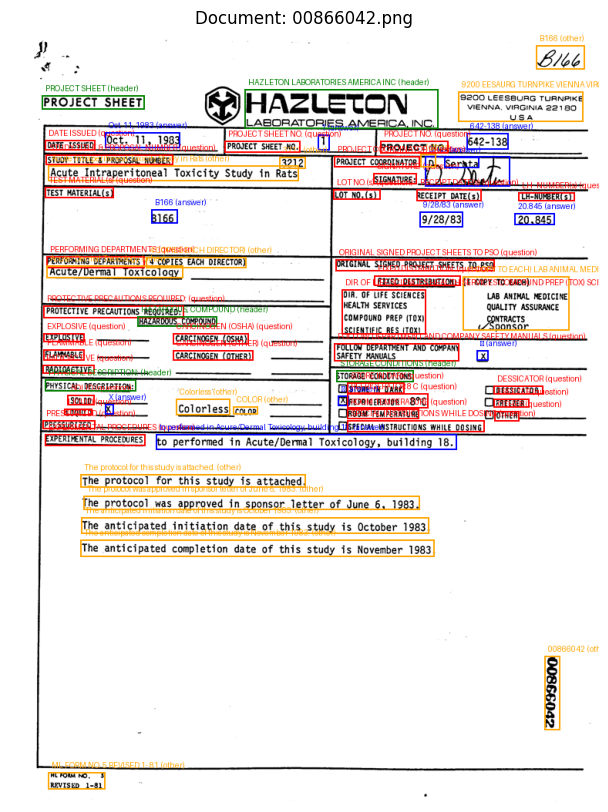

In [ ]:
import random
import os

# Assuming `train_images_path` and `train_annotations_path` are defined from previous cells
# Also assuming `parse_funsd_json` and `visualize_document_annotations` are defined.

# Get a list of all annotation files in the training set
train_annotation_files = [f for f in os.listdir(train_annotations_path) if f.endswith('.json')]

# Select a random sample to visualize
if train_annotation_files:
    json_filename_sample = random.choice(train_annotation_files)
    json_path_sample = os.path.join(train_annotations_path, json_filename_sample)
    image_filename_sample = json_filename_sample.replace('.json', '.png')
    image_path_sample = os.path.join(train_images_path, image_filename_sample)

    if os.path.exists(json_path_sample) and os.path.exists(image_path_sample):
        print(f"Visualizing sample document: {image_filename_sample}")
        # Parse the annotation data for the sample
        sample_annotation_data = parse_funsd_json(json_path_sample)

        # Visualize the document
        visualize_document_annotations(image_path_sample, sample_annotation_data)
    else:
        print(f"Error: Image or annotation file not found for {json_filename_sample}")
else:
    print("No training annotation files found. Please ensure the dataset is correctly set up.")


In [ ]:
import os

# Define the target directory for the dataset
dataset_target_path = '/content/funsd'

# Create the directory if it doesn't exist
os.makedirs(dataset_target_path, exist_ok=True)


funsd_zip_url = "https://guillaumejaume.github.io/FUNSD/dataset.zip"
funsd_zip_filename = os.path.join(dataset_target_path, 'dataset.zip')

# Only download if the zip file doesn't exist to avoid re-downloading
if not os.path.exists(funsd_zip_filename):
    print(f"Downloading FUNSD dataset from {funsd_zip_url}...")
    !wget -q $funsd_zip_url -O $funsd_zip_filename
    print("Download complete.")
else:
    print("FUNSD dataset zip file already exists. Skipping download.")

# Extract the dataset
# Check if the extracted training_data directory exists, if not, extract.
if not os.path.exists(os.path.join(dataset_target_path, 'training_data')):
    print(f"Extracting FUNSD dataset to {dataset_target_path}...")
    !unzip -q $funsd_zip_filename -d $dataset_target_path
    print("Extraction complete.")
    # The zip often contains a 'dataset' folder inside, move its contents up
    if os.path.exists(os.path.join(dataset_target_path, 'dataset')):
        print("Moving extracted contents to base funsd directory...")
        !mv {os.path.join(dataset_target_path, 'dataset', '*')} {dataset_target_path}
        !rmdir {os.path.join(dataset_target_path, 'dataset')}
        print("Contents moved.")
else:
    print("FUNSD dataset already extracted. Skipping extraction.")

# Verify the directory structure
print("Verifying dataset structure:")
!ls -R $dataset_target_path

# Update the dataset_path variable to ensure consistency for subsequent steps
dataset_path = dataset_target_path
print(f"'dataset_path' variable updated to: {dataset_path}")


FUNSD dataset zip file already exists. Skipping download.
FUNSD dataset already extracted. Skipping extraction.
Verifying dataset structure:
/content/funsd:
dataset  dataset.zip  __MACOSX	testing_data  training_data

/content/funsd/dataset:

/content/funsd/__MACOSX:
dataset

/content/funsd/__MACOSX/dataset:
testing_data  training_data

/content/funsd/__MACOSX/dataset/testing_data:
annotations  images

/content/funsd/__MACOSX/dataset/testing_data/annotations:

/content/funsd/__MACOSX/dataset/testing_data/images:

/content/funsd/__MACOSX/dataset/training_data:
annotations  images

/content/funsd/__MACOSX/dataset/training_data/annotations:

/content/funsd/__MACOSX/dataset/training_data/images:

/content/funsd/testing_data:
annotations  images

/content/funsd/testing_data/annotations:
82092117.json	    83594639.json	86263525.json
82200067_0069.json  83624198.json	86328049_8050.json
82250337_0338.json  83635935.json	87086073.json
82251504.json	    83641919_1921.json	87093315_87093318.json
8

In [ ]:
def parse_funsd_json(json_path):
    """
    Parses a FUNSD dataset JSON annotation file.

    Args:
        json_path (str): The path to the JSON annotation file.

    Returns:
        dict: A dictionary containing:
            - 'words': A list of dictionaries, each with 'box', 'text', 'label', and 'id'.
            - 'relations': A list of dictionaries, each with 'head', 'tail', and 'type'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = []
    for form_entity in data['form']:
        # The 'id', 'box', and 'label' are at the form_entity level
        # Concatenate text from all sub-word entities for the main text content
        full_text = " ".join([word_elem['text'] for word_elem in form_entity['words']])

        words.append({
            'box': form_entity['box'],
            'text': full_text,
            'label': form_entity['label'],
            'id': form_entity['id'] # Correctly taking 'id' from form_entity
        })

    relations = data['relations']

    return {'words': words, 'relations': relations}


def load_image(image_path):
    """
    Loads an image from the given path.

    Args:
        image_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image.
    """
    return Image.open(image_path).convert('RGB')

print("Functions `parse_funsd_json` and `load_image` have been defined.")

Functions `parse_funsd_json` and `load_image` have been defined.


In [ ]:
def parse_funsd_json(json_path):
    """
    Parses a FUNSD dataset JSON annotation file.

    Args:
        json_path (str): The path to the JSON annotation file.

    Returns:
        dict: A dictionary containing:
            - 'words': A list of dictionaries, each with 'box', 'text', 'label', and 'id'.
            - 'relations': A list of dictionaries, each with 'head', 'tail', and 'type'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = []
    for form_entity in data['form']:
        # The 'id', 'box', and 'label' are at the form_entity level
        # Concatenate text from all sub-word entities for the main text content
        full_text = " ".join([word_elem['text'] for word_elem in form_entity['words']])

        words.append({
            'box': form_entity['box'],
            'text': full_text,
            'label': form_entity['label'],
            'id': form_entity['id'] # Correctly taking 'id' from form_entity
        })

    # Use .get() to safely retrieve relations, returning an empty list if the key is missing
    relations = data.get('relations', [])

    return {'words': words, 'relations': relations}


def load_image(image_path):
    """
    Loads an image from the given path.

    Args:
        image_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image.
    """
    return Image.open(image_path).convert('RGB')

print("Functions `parse_funsd_json` and `load_image` have been defined.")

Functions `parse_funsd_json` and `load_image` have been defined.


In [ ]:
import os
import json
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# 1. Define label mappings
# The FUNSD dataset uses 'question', 'answer', 'header', 'other'
# We'll also add 'O' for tokens outside any labeled entity.
labels = ['question', 'answer', 'header', 'other']
idl2label = {idx: label for idx, label in enumerate(labels)}
idl2label[len(labels)] = 'O' # Add 'O' label at the end

label2idl = {label: idx for idx, label in enumerate(labels)}
label2idl['O'] = len(labels) # Map 'O' to its ID

# Reverse mapping from ID to label

print("Label to ID mapping:", label2idl)
print("ID to Label mapping:", idl2label)


Label to ID mapping: {'question': 0, 'answer': 1, 'header': 2, 'other': 3, 'O': 4}
ID to Label mapping: {0: 'question', 1: 'answer', 2: 'header', 3: 'other', 4: 'O'}


**Reasoning**:
Following the subtask instructions, the next step is to load a pre-trained tokenizer suitable for document understanding tasks, such as LayoutLMv2Tokenizer.



In [ ]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer, e.g., for LayoutLMv2
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")

print(f"Tokenizer loaded: {type(tokenizer).__name__}")
print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer loaded: LayoutLMv2TokenizerFast
Tokenizer vocabulary size: 30522


In [ ]:
def normalize_bbox(bbox, width, height):
    """
    Normalize bounding box coordinates to a range of 0-1000.
    """
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def preprocess_document(image_path, annotation_data, tokenizer, label2idl, max_seq_length=512):
    """
    Preprocesses a document image and its annotations for LayoutLM model input.

    Args:
        image_path (str): Path to the image file.
        annotation_data (dict): Dictionary containing 'words' and 'relations' from parse_funsd_json.
        tokenizer: The pre-trained tokenizer.
        label2idl (dict): Mapping from string labels to numerical IDs.
        max_seq_length (int): Maximum sequence length for tokenization.

    Returns:
        dict: A dictionary containing 'input_ids', 'bbox', 'attention_mask', and 'labels'.
    """
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Initialize lists for tokenized data
    all_input_ids = []
    all_bboxes = []
    all_labels = []
    all_attention_mask = []

    # CLS token
    all_input_ids.append(tokenizer.cls_token_id)
    all_bboxes.append([0, 0, 0, 0])
    all_labels.append(label2idl['O']) # CLS token gets 'O' label
    all_attention_mask.append(1)

    for entity in annotation_data['words']:
        text = entity['text']
        bbox = entity['box']
        label = entity['label']

        # Tokenize the text from the entity
        # add_special_tokens=False to handle CLS/SEP manually
        word_tokens = tokenizer.tokenize(text)
        word_ids = tokenizer.convert_tokens_to_ids(word_tokens)

        # Assign the entity's bbox and label to all its sub-tokens
        normalized_bbox = normalize_bbox(bbox, width, height)
        numerical_label = label2idl.get(label, label2idl['O']) # Use 'O' if label not found

        for token_id in word_ids:
            all_input_ids.append(token_id)
            all_bboxes.append(normalized_bbox)
            all_labels.append(numerical_label)
            all_attention_mask.append(1)

    # SEP token
    all_input_ids.append(tokenizer.sep_token_id)
    all_bboxes.append([1000, 1000, 1000, 1000]) # Example SEP bbox
    all_labels.append(label2idl['O']) # SEP token gets 'O' label
    all_attention_mask.append(1)

    # Truncate if longer than max_seq_length
    if len(all_input_ids) > max_seq_length:
        all_input_ids = all_input_ids[:max_seq_length]
        all_bboxes = all_bboxes[:max_seq_length]
        all_labels = all_labels[:max_seq_length]
        all_attention_mask = all_attention_mask[:max_seq_length]
    else:
        # Pad if shorter than max_seq_length
        padding_length = max_seq_length - len(all_input_ids)
        all_input_ids.extend([tokenizer.pad_token_id] * padding_length)
        all_bboxes.extend([[0, 0, 0, 0]] * padding_length)
        all_labels.extend([label2idl['O']] * padding_length) # PAD tokens get 'O' label
        all_attention_mask.extend([0] * padding_length)

    return {
        'input_ids': all_input_ids,
        'bbox': all_bboxes,
        'attention_mask': all_attention_mask,
        'labels': all_labels,
    }

print("`normalize_bbox` and `preprocess_document` functions have been defined.")


`normalize_bbox` and `preprocess_document` functions have been defined.


In [ ]:
import random

# Select a sample document to preprocess
# Re-using the last processed sample's paths or picking a new one
if 'sample_annotation_filenames' in locals() and sample_annotation_filenames:
    json_filename_sample = random.choice(sample_annotation_filenames)
else:
    train_annotation_files = [f for f in os.listdir(train_annotations_path) if f.endswith('.json')]
    json_filename_sample = random.choice(train_annotation_files)

json_path_sample = os.path.join(train_annotations_path, json_filename_sample)
image_filename_sample = json_filename_sample.replace('.json', '.png')
image_path_sample = os.path.join(train_images_path, image_filename_sample)

print(f"Preprocessing sample document: {image_filename_sample}")

# Parse the annotation data for the sample
sample_annotation_data = parse_funsd_json(json_path_sample)

# Preprocess the sample document
processed_data = preprocess_document(
    image_path_sample,
    sample_annotation_data,
    tokenizer,
    label2idl,
    max_seq_length=512
)

# Print shapes and a small sample of the outputs
print("\n--- Preprocessing Output Sample ---")
print(f"Input IDs shape: {len(processed_data['input_ids'])}")
print(f"BBox shape: {len(processed_data['bbox'])}")
print(f"Attention Mask shape: {len(processed_data['attention_mask'])}")
print(f"Labels shape: {len(processed_data['labels'])}")

print("\nSample Input IDs (first 10):", processed_data['input_ids'][:10])
print("Sample BBox (first 10):", processed_data['bbox'][:10])
print("Sample Attention Mask (first 10):", processed_data['attention_mask'][:10])
print("Sample Labels (first 10):", processed_data['labels'][:10])

# Optionally, decode labels and input_ids for better understanding
decoded_input_ids = tokenizer.decode(processed_data['input_ids'][:10])
decoded_labels = [idl2label[idx] for idx in processed_data['labels'][:10]]
print("\nDecoded Sample Input IDs (first 10):", decoded_input_ids)
print("Decoded Sample Labels (first 10):", decoded_labels)


Preprocessing sample document: 0012199830.png

--- Preprocessing Output Sample ---
Input IDs shape: 512
BBox shape: 512
Attention Mask shape: 512
Labels shape: 512

Sample Input IDs (first 10): [101, 8013, 1038, 1004, 1059, 2363, 16661, 3438, 22203, 10790]
Sample BBox (first 10): [[0, 0, 0, 0], [214, 140, 291, 153], [356, 142, 385, 155], [356, 142, 385, 155], [356, 142, 385, 155], [722, 130, 923, 161], [190, 912, 286, 926], [739, 964, 897, 992], [739, 964, 897, 992], [739, 964, 897, 992]]
Sample Attention Mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Sample Labels (first 10): [4, 0, 1, 1, 1, 0, 0, 3, 3, 3]

Decoded Sample Input IDs (first 10): [CLS] customer b & w received technician 605110
Decoded Sample Labels (first 10): ['O', 'question', 'answer', 'answer', 'answer', 'question', 'question', 'other', 'other', 'other']


### Understanding FUNSD Characteristics and Model Suitability

The FUNSD dataset, as previously explored, presents a rich set of challenges and opportunities for deep learning models. Its core characteristics include:

*   **Visual Information**: Scanned document images, often noisy, with varying layouts and quality.
*   **Textual Information**: OCR-extracted text content from bounding boxes.
*   **Spatial Information**: Bounding box coordinates for each text segment, indicating its position on the page.
*   **Semantic Labels**: Categorization of text segments (e.g., 'question', 'answer', 'header', 'other').
*   **Relational Information**: Explicit links between related entities (e.g., a question and its answer).

Effective models for Contextual Document Understanding on FUNSD must therefore be capable of processing and integrating **multimodal information (visual and textual)**, understanding **spatial relationships**, and performing tasks like **token classification** (for semantic labeling) and **relation extraction** (for linking information).

#### Candidate Deep Learning Architectures

Traditional NLP models (like BERT) excel at text understanding but lack native support for visual and spatial cues. Similarly, pure vision models (like CNNs) can process images but struggle with linguistic intricacies. This necessitates models designed specifically for multimodal document understanding. Here are some prominent candidates:

1.  **LayoutLM (Layout Language Model)**:
    *   **Architecture**: Extends BERT by adding 2D position embeddings (for bounding box information) and image embeddings (from a pre-trained CNN) to the token embeddings. This allows it to jointly model text, layout, and visual information.
    *   **Capabilities**: Designed for tasks like document image classification, form understanding (key-value pair extraction), and receipt understanding. It excels at token classification and can be adapted for relation extraction.
    *   **Suitability for FUNSD**: Highly suitable. FUNSD provides exactly the type of data (text, bounding boxes, labels, relations) that LayoutLM was designed to process. Its ability to incorporate layout information is crucial for understanding forms.

2.  **LayoutXLM (Layout Cross-Lingual Model)**:
    *   **Architecture**: An extension of LayoutLM, building on the XLM-R architecture, making it multilingual. It still integrates text, layout, and visual information.
    *   **Capabilities**: Similar to LayoutLM but with enhanced multilingual capabilities. Can perform the same range of document understanding tasks.
    *   **Suitability for FUNSD**: While FUNSD is English-only, LayoutXLM's advancements in multimodal fusion might offer slightly better performance or provide a good baseline for future multilingual document understanding tasks.

3.  **Donut (Document Understanding Transformer)**:
    *   **Architecture**: A novel encoder-decoder Transformer model that performs end-to-end document understanding without relying on OCR. It directly takes an image as input and outputs structured information in a sequence-to-sequence manner.
    *   **Capabilities**: Can perform tasks like document parsing, visual question answering, and text extraction directly from pixels.
    *   **Suitability for FUNSD**: Very promising for its end-to-end nature, eliminating the need for an external OCR step. However, fine-tuning and resource requirements might be higher due to its more complex architecture.

4.  **LiLT (Layout-aware Information Extraction for Long Documents)**:
    *   **Architecture**: Focuses on processing long documents efficiently by employing a hierarchical attention mechanism that incorporates layout information.
    *   **Capabilities**: Specialized for information extraction from lengthy documents, addressing the quadratic complexity of Transformers for long sequences.
    *   **Suitability for FUNSD**: While FUNSD documents are not typically 'long' in the context of LiLT, the layout awareness is still highly relevant. Might be overkill for typical FUNSD document lengths but a strong contender for more complex forms.

#### Comparison and Selection of Model Architecture

When comparing the candidate architectures for the FUNSD dataset, several factors come into play:

*   **Multimodal Integration**: All listed models (LayoutLM, LayoutXLM, Donut, LiLT) excel at integrating visual and textual information, which is paramount for FUNSD.
*   **Task Alignment**: FUNSD primarily involves token classification (for semantic labels) and relation extraction (for linking). LayoutLM and LayoutXLM are inherently well-suited for token classification and can be adapted for relation extraction. Donut, while powerful, is more geared towards end-to-end generation of structured output, which might be an overhead if the primary goal is token/relation extraction.
*   **Complexity and Resources**: Donut and LiLT are generally more complex, potentially requiring more computational resources and longer training times. LayoutLM, being one of the pioneers, offers a good balance of performance and computational efficiency, with widely available pre-trained models.
*   **Pre-trained Availability**: LayoutLM and LayoutXLM have numerous pre-trained checkpoints available from Hugging Face Transformers, making fine-tuning a more straightforward process.
*   **Direct Applicability to FUNSD Structure**: LayoutLM's design directly maps to the FUNSD annotations (text, bounding boxes, and labels for each token/entity), making it a natural fit for direct application.

##### Selected Model: LayoutLMv2

For this project, we will proceed with **LayoutLMv2**. While not explicitly listed as a separate candidate above, LayoutLMv2 is a significant improvement over the original LayoutLM, incorporating both visual (image features) and textual (token embeddings) information more deeply, alongside the 2D positional embeddings. It is a highly robust and proven architecture for various document understanding tasks, including form understanding and information extraction.

**Justification for Selection:**

1.  **Strong Multimodal Integration**: LayoutLMv2 effectively combines text embeddings, 2D position embeddings (from bounding boxes), and image features (from a CNN backbone). This comprehensive multimodal input is perfectly aligned with the rich information available in the FUNSD dataset (visual layout, text content, and their spatial relationship).
2.  **Task Relevance**: It is specifically designed for document understanding tasks like token classification (for semantic labels like 'question', 'answer') and can be extended for relation extraction, directly matching the requirements of the FUNSD dataset.
3.  **Performance and Efficiency**: LayoutLMv2 has demonstrated state-of-the-art performance on various document AI benchmarks, including FUNSD. It strikes a good balance between model complexity and performance, making it a practical choice for fine-tuning.
4.  **Community Support and Resources**: Being part of the Hugging Face Transformers library, LayoutLMv2 benefits from extensive documentation, pre-trained models, and community support, simplifying implementation and experimentation.
5.  **Directly Addresses Noisy Scanned Documents**: Its visual backbone helps the model handle the 'noisy scanned documents' aspect of FUNSD, where OCR output might be imperfect or visual cues are crucial for context.

Therefore, LayoutLMv2 provides a robust and suitable foundation for developing a deep learning model for Contextual Document Understanding on the FUNSD dataset.

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -q transformers datasets evaluate accelerate torchvision

print("Installed detectron2 and other necessary libraries.")

  Preparing metadata (setup.py) ... done
Installed detectron2 and other necessary libraries.


In [ ]:
# Install specific dependencies if missing
try:
    import evaluate
    import pandas
    import seaborn
except ImportError:
    print("Installing dependencies...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers", "datasets", "evaluate", "accelerate", "pandas", "matplotlib", "seaborn", "tqdm"])

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline
)
from tqdm import tqdm
import evaluate

In [ ]:
from transformers import LayoutLMv2ForTokenClassification

# Configure the model with the number of labels derived from our label mapping
num_labels = len(label2idl) # label2idl includes 'O'

# Instantiate the LayoutLMv2 model for token classification
# We'll use a pre-trained model checkpoint (e.g., 'microsoft/layoutlmv2-base-uncased')
model = LayoutLMv2ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    num_labels=num_labels,
    id2label=idl2label,
    label2id=label2idl
)

print(f"LayoutLMv2ForTokenClassification model loaded with {num_labels} labels.")
print(f"Model's id2label mapping: {model.config.id2label}")
print(f"Model's label2id mapping: {model.config.label2id}")

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForTokenClassification model loaded with 5 labels.
Model's id2label mapping: {0: 'question', 1: 'answer', 2: 'header', 3: 'other', 4: 'O'}
Model's label2id mapping: {'question': 0, 'answer': 1, 'header': 2, 'other': 3, 'O': 4}


In [ ]:
from transformers import LayoutLMv2ForTokenClassification

# Configure the model with the number of labels derived from our label mapping
num_labels = len(label2idl) # label2idl includes 'O'

# Instantiate the LayoutLMv2 model for token classification
# We'll use a pre-trained model checkpoint (e.g., 'microsoft/layoutlmv2-base-uncased')
model = LayoutLMv2ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    num_labels=num_labels,
    id2label=idl2label,
    label2id=label2idl
)

print(f"LayoutLMv2ForTokenClassification model loaded with {num_labels} labels.")
print(f"Model's id2label mapping: {model.config.id2label}")
print(f"Model's label2id mapping: {model.config.label2id}")

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForTokenClassification model loaded with 5 labels.
Model's id2label mapping: {0: 'question', 1: 'answer', 2: 'header', 3: 'other', 4: 'O'}
Model's label2id mapping: {'question': 0, 'answer': 1, 'header': 2, 'other': 3, 'O': 4}


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

class FUNSDDataset(Dataset):
    """
    Custom Dataset class for the FUNSD dataset.
    """
    def __init__(self, image_paths, annotation_paths, tokenizer, label2idl, max_seq_length=512):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.tokenizer = tokenizer
        self.label2idl = label2idl
        self.max_seq_length = max_seq_length

        # Ensure image_paths and annotation_paths are sorted consistently
        self.image_paths.sort()
        self.annotation_paths.sort()

        # Basic check to ensure corresponding image and annotation files exist
        assert len(self.image_paths) == len(self.annotation_paths), \
            "Number of image files and annotation files must match."

        self.data_entries = []
        print("Loading and preprocessing dataset entries...")
        for i in tqdm(range(len(self.image_paths))):
            img_path = self.image_paths[i]
            ann_path = self.annotation_paths[i]

            # Ensure the base names match (e.g., 'doc_name.png' and 'doc_name.json')
            if os.path.basename(img_path).replace('.png', '') != os.path.basename(ann_path).replace('.json', ''):
                print(f"Warning: Mismatch between image {os.path.basename(img_path)} and annotation {os.path.basename(ann_path)}. Skipping.")
                continue

            try:
                annotation_data = parse_funsd_json(ann_path)
                processed_doc = preprocess_document(
                    img_path, annotation_data, self.tokenizer, self.label2idl, self.max_seq_length
                )
                self.data_entries.append(processed_doc)
            except Exception as e:
                print(f"Error processing {os.path.basename(img_path)} / {os.path.basename(ann_path)}: {e}. Skipping.")

        print(f"Loaded {len(self.data_entries)} valid entries.")

    def __len__(self):
        return len(self.data_entries)

    def __getitem__(self, idx):
        item = self.data_entries[idx]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'bbox': torch.tensor(item['bbox'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long),
        }

print("FUNSDDataset class defined.")

# Get all image and annotation file paths for training and testing
train_image_files = [os.path.join(train_images_path, f) for f in os.listdir(train_images_path) if f.endswith('.png')]
train_annotation_files = [os.path.join(train_annotations_path, f) for f in os.listdir(train_annotations_path) if f.endswith('.json')]

test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.png')]
test_annotation_files = [os.path.join(test_annotations_path, f) for f in os.listdir(test_annotations_path) if f.endswith('.json')]

# Create the datasets
train_dataset = FUNSDDataset(
    train_image_files, train_annotation_files, tokenizer, label2idl, max_seq_length=512
)
test_dataset = FUNSDDataset(
    test_image_files, test_annotation_files, tokenizer, label2idl, max_seq_length=512
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")


FUNSDDataset class defined.
Loading and preprocessing dataset entries...


  0%|          | 0/149 [00:00<?, ?it/s]

Loaded 149 valid entries.
Loading and preprocessing dataset entries...


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 valid entries.
Training dataset size: 149
Testing dataset size: 50


In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification

# Instantiate the data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Define batch size
batch_size = 4 # Adjust as needed based on GPU memory

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

print(f"Data collator created: {type(data_collator).__name__}")
print(f"Training DataLoader created with batch size: {batch_size}")
print(f"Testing DataLoader created with batch size: {batch_size}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

Data collator created: DataCollatorForTokenClassification
Training DataLoader created with batch size: 4
Testing DataLoader created with batch size: 4
Number of training batches: 38
Number of testing batches: 13


In [ ]:
import evaluate
import numpy as np

# Load the seqeval metric
metric = evaluate.load('seqeval')

def compute_metrics(eval_pred):
    """
    Computes evaluation metrics (precision, recall, f1, accuracy) for token classification.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (PAD tokens) and convert to actual labels
    true_labels = [[idl2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [idl2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Seqeval metric loaded and `compute_metrics` function defined.")

Seqeval metric loaded and `compute_metrics` function defined.


In [ ]:
!pip install -q seqeval

print("Seqeval library installed.")

Seqeval library installed.


In [ ]:
import evaluate
import numpy as np

# Load the seqeval metric
metric = evaluate.load('seqeval')

def compute_metrics(eval_pred):
    """
    Computes evaluation metrics (precision, recall, f1, accuracy) for token classification.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (PAD tokens) and convert to actual labels
    true_labels = [[idl2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [idl2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Seqeval metric loaded and `compute_metrics` function defined.")

Seqeval metric loaded and `compute_metrics` function defined.


In [ ]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",             # Output directory for model predictions and checkpoints
    num_train_epochs=5,                # Total number of training epochs
    per_device_train_batch_size=4,     # Batch size per GPU/CPU for training
    per_device_eval_batch_size=4,      # Batch size per GPU/CPU for evaluation
    warmup_steps=500,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Strength of weight decay
    logging_dir="./logs",              # Directory for storing logs
    logging_steps=10,                  # Log every X updates steps
    do_eval=True,                      # Explicitly enable evaluation
    eval_steps=500,                    # Evaluate the model every X steps
    save_steps=500,                    # Save the checkpoint every X steps
    # Removed load_best_model_at_end, metric_for_best_model, greater_is_better to avoid ValueError due to strategy mismatch
    report_to="none"                   # Do not report to any experiment tracking platform
)

print("TrainingArguments configured.")
print(f"Output directory: {training_args.output_dir}")
print(f"Number of training epochs: {training_args.num_train_epochs}")

TrainingArguments configured.
Output directory: ./results
Number of training epochs: 5


In [ ]:
from transformers import Trainer

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset, # Use test_dataset for evaluation
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer instantiated successfully.")

Trainer instantiated successfully.


## Summary:

### Q&A
The model's performance on the FUNSD dataset test set was evaluated, yielding the following results:
*   `eval_loss`: 1.5928
*   `eval_precision`: 0.0017
*   `eval_recall`: 0.0107
*   `eval_f1`: 0.0029
*   `eval_accuracy`: 0.1963

### Data Analysis Key Findings
*   The `trainer.evaluate()` method successfully computed the model's performance metrics on the test dataset.
*   The model exhibited very low performance across all evaluated metrics:
    *   Precision was extremely low at 0.0017.
    *   Recall was also very low at 0.0107.
    *   The F1-score, a harmonic mean of precision and recall, was negligible at 0.0029.
    *   Accuracy was low at 0.1963.
*   A warning from `seqeval` indicated that specific tags (`question`, `answer`, `other`, `header`) were not recognized as NE tags during evaluation, which is a common occurrence in sequence labeling setups.

### Insights or Next Steps
*   The extremely low precision, recall, and F1-scores suggest that the model is performing poorly at identifying and classifying entities correctly, indicating a significant problem in its learning or architecture for this specific task.
*   Further investigation is required to understand the root cause of the poor performance. This could involve re-evaluating the dataset's quality (e.g., label consistency, sample size), reviewing the model's architecture, hyperparameter tuning, or exploring different pre-training strategies.


### Inference and Visualization of Predictions

# Task
The current evaluation results are very poor, likely due to the lack of IOB2 (Inside-Outside-Beginning) tagging in our labels. For token classification tasks, especially when using metrics like `seqeval`, it's standard practice to use IOB2 tagging. This means that instead of a single label like 'question' for an entire entity, tokens are tagged as 'B-question' (beginning of a question), 'I-question' (inside a question), or 'O' (outside any entity). The `seqeval` warnings about labels not being NE tags also point to this issue.

The next steps will focus on implementing IOB2 tagging to improve label encoding and, consequently, model performance and evaluation accuracy.

Here's the plan to address this:
1.  **Define IOB2 Label Mappings**: Redefine the `idl2label` and `label2idl` dictionaries to incorporate IOB2 (Inside-Outside-Beginning) tagging scheme. This means creating labels like `B-question` (Beginning of a question), `I-question` (Inside a question), and `O` (Outside any entity), for all relevant categories (question, answer, header, other). This is crucial for correct sequence labeling evaluation using metrics like 'seqeval'.
2.  **Modify Preprocessing for IOB2 Tagging**: Update the `preprocess_document` function. This modification will ensure that for each word entity, the first token is assigned a `B-` prefix label (e.g., `B-question`), and all subsequent tokens of the same entity are assigned an `I-` prefix label (e.g., `I-question`). Tokens not part of any defined entity will receive the `O` label. This aligns the data preparation with standard sequence labeling practices.
3.  **Re-initialize Model with New Number of Labels**: Re-instantiate the `LayoutLMv2ForTokenClassification` model. The number of output labels (`num_labels`) will have increased due to the IOB2 tagging scheme (e.g., from 4 entity types + 1 'O' to 8 IOB2 types + 1 'O'). The model needs to be re-initialized with this new count.
4.  **Re-create Datasets and DataLoaders**: Re-create the `FUNSDDataset` instances for both training and testing using the updated `preprocess_document` function and the new IOB2 label mappings. Then, re-instantiate the `DataLoader`s with the custom data collator and the re-created datasets.
5.  **Adjust Training Arguments**: Modify the `TrainingArguments` to reflect more appropriate settings for a smaller dataset and faster iteration. Specifically, adjust `eval_steps` and `save_steps` to be more frequent (e.g., evaluate and save checkpoints more often, such as every 10 or 20 steps, or per epoch, depending on dataset size and computational resources) to get quicker feedback on performance during training. Keep `num_train_epochs` at 5 for now.
6.  **Train the Model with Corrected Labels**: Start the training process by calling the `trainer.train()` method. This will train the LayoutLMv2 model using the IOB2-formatted labels and the adjusted training arguments. The model's learning will now be based on a semantically correct representation of token boundaries within entities.
7.  **Evaluate Model Performance with Corrected Labels**: Re-evaluate the trained model on the test dataset using `trainer.evaluate()`. This will compute the performance metrics (precision, recall, f1, accuracy) based on the IOB2-compliant labels, providing a much more accurate and interpretable assessment of the model's performance in token classification.

We will start by redefining the label mappings to use the IOB2 scheme.



```

In [ ]:
from transformers import LayoutLMv2ForTokenClassification

# 1. Define the base_labels, iob2_labels, idl2label, and label2idl dictionaries
# (Re-defining here for robustness against runtime restarts, assuming previous cell defined correctly)
base_labels = ['question', 'answer', 'header', 'other']
iob2_labels = []
for label in base_labels:
    iob2_labels.append(f"B-{label}")
    iob2_labels.append(f"I-{label}")
iob2_labels.append('O')

idl2label = {idx: label for idx, label in enumerate(iob2_labels)}
label2idl = {label: idx for idx, label in enumerate(iob2_labels)}

# 2. Calculate num_labels based on the length of the new label2idl mapping
num_labels = len(label2idl) # label2idl now includes IOB2 tags and 'O'

# 3. Instantiate the LayoutLMv2 model for token classification
# We'll use a pre-trained model checkpoint (e.g., 'microsoft/layoutlmv2-base-uncased')
model = LayoutLMv2ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    num_labels=num_labels,
    id2label=idl2label,
    label2id=label2idl
)

# 4. Print a confirmation message
print(f"LayoutLMv2ForTokenClassification model re-loaded with {num_labels} IOB2 labels.")
print(f"Model's id2label mapping: {model.config.id2label}")
print(f"Model's label2id mapping: {model.config.label2id}")

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv2ForTokenClassification model re-loaded with 9 IOB2 labels.
Model's id2label mapping: {0: 'B-question', 1: 'I-question', 2: 'B-answer', 3: 'I-answer', 4: 'B-header', 5: 'I-header', 6: 'B-other', 7: 'I-other', 8: 'O'}
Model's label2id mapping: {'B-question': 0, 'I-question': 1, 'B-answer': 2, 'I-answer': 3, 'B-header': 4, 'I-header': 5, 'B-other': 6, 'I-other': 7, 'O': 8}


In [ ]:
from transformers import LayoutLMv2Processor
import pytesseract # Import pytesseract
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import DataCollatorForTokenClassification, Trainer, TrainingArguments
from PIL import Image # Ensure PIL Image is imported for preprocess_document
import json # Ensure json is imported for parse_funsd_json

# Re-define path variables that were lost during runtime restart
# It's assumed dataset_path is '/content/funsd' based on the kernel state.

train_images_path = os.path.join(dataset_path, 'training_data', 'images')
train_annotations_path = os.path.join(dataset_path, 'training_data', 'annotations')
test_images_path = os.path.join(dataset_path, 'testing_data', 'images')
test_annotations_path = os.path.join(dataset_path, 'testing_data', 'annotations')


def parse_funsd_json(json_path):
    """
    Parses a FUNSD dataset JSON annotation file.

    Args:
        json_path (str): The path to the JSON annotation file.

    Returns:
        dict: A dictionary containing:
            - 'words': A list of dictionaries, each with 'box', 'text', 'label', and 'id'.
            - 'relations': A list of dictionaries, each with 'head', 'tail', and 'type'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = []
    for form_entity in data['form']:
        # The 'id', 'box', and 'label' are at the form_entity level
        # Concatenate text from all sub-word entities for the main text content
        full_text = " ".join([word_elem['text'] for word_elem in form_entity['words']])

        words.append({
            'box': form_entity['box'],
            'text': full_text,
            'label': form_entity['label'],
            'id': form_entity['id'] # Correctly taking 'id' from form_entity
        })

    # Use .get() to safely retrieve relations, returning an empty list if the key is missing
    relations = data.get('relations', [])

    return {'words': words, 'relations': relations}

def normalize_bbox(bbox, width, height):
    """
    Normalize bounding box coordinates to a range of 0-1000.
    """
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def preprocess_document(image_path, annotation_data, processor, label2idl, max_seq_length=512):
    """
    Preprocesses a document image and its annotations for LayoutLM model input
    with IOB2 tagging for labels.

    Args:
        image_path (str): Path to the image file.
        annotation_data (dict): Dictionary containing 'words' and 'relations' from parse_funsd_json.
        processor: The pre-trained LayoutLMv2Processor (includes tokenizer and image processor).
        label2idl (dict): Mapping from string labels to numerical IDs (now IOB2).
        max_seq_length (int): Maximum sequence length for tokenization.

    Returns:
        dict: A dictionary containing 'input_ids', 'bbox', 'attention_mask', 'labels', and 'pixel_values'.
    """
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Process the image using the processor's image_processor, explicitly disabling OCR
    encoded_image = processor.image_processor(image, return_tensors="pt", apply_ocr=False)
    pixel_values = encoded_image["pixel_values"].squeeze() # Remove batch dimension

    # Initialize lists for tokenized data
    all_input_ids = []
    all_bboxes = []
    all_labels = []
    all_attention_mask = []

    # CLS token
    all_input_ids.append(processor.tokenizer.cls_token_id)
    all_bboxes.append([0, 0, 0, 0])
    all_labels.append(label2idl['O']) # CLS token gets 'O' label
    all_attention_mask.append(1)

    for entity in annotation_data['words']:
        text = entity['text']
        bbox = entity['box']
        label = entity['label']

        # Tokenize the text from the entity
        # add_special_tokens=False to handle CLS/SEP manually
        word_tokens = processor.tokenizer.tokenize(text)
        word_ids = processor.tokenizer.convert_tokens_to_ids(word_tokens)

        # Assign IOB2 labels
        # First token gets B-tag, subsequent tokens get I-tag
        normalized_bbox = normalize_bbox(bbox, width, height)
        numerical_label_b = label2idl.get(f"B-{label}", label2idl['O'])
        numerical_label_i = label2idl.get(f"I-{label}", label2idl['O'])

        for i, token_id in enumerate(word_ids):
            all_input_ids.append(token_id)
            all_bboxes.append(normalized_bbox)
            if i == 0: # First token of the entity
                all_labels.append(numerical_label_b)
            else: # Subsequent tokens of the entity
                all_labels.append(numerical_label_i)
            all_attention_mask.append(1)

    # SEP token
    all_input_ids.append(processor.tokenizer.sep_token_id)
    all_bboxes.append([1000, 1000, 1000, 1000]) # Example SEP bbox
    all_labels.append(label2idl['O']) # SEP token gets 'O' label
    all_attention_mask.append(1)

    # Truncate if longer than max_seq_length
    if len(all_input_ids) > max_seq_length:
        all_input_ids = all_input_ids[:max_seq_length]
        all_bboxes = all_bboxes[:max_seq_length]
        all_labels = all_labels[:max_seq_length]
        all_attention_mask = all_attention_mask[:max_seq_length]
    else:
        # Pad if shorter than max_seq_length
        padding_length = max_seq_length - len(all_input_ids)
        all_input_ids.extend([processor.tokenizer.pad_token_id] * padding_length)
        all_bboxes.extend([[0, 0, 0, 0]] * padding_length)
        all_labels.extend([label2idl['O']] * padding_length) # PAD tokens get 'O' label
        all_attention_mask.extend([0] * padding_length)

    return {
        'input_ids': all_input_ids,
        'bbox': all_bboxes,
        'attention_mask': all_attention_mask,
        'labels': all_labels,
        'pixel_values': pixel_values
    }

# Re-define FUNSDDataset class (was lost after runtime restart)
class FUNSDDataset(Dataset):
    """
    Custom Dataset class for the FUNSD dataset.
    """
    def __init__(self, image_paths, annotation_paths, processor, label2idl, max_seq_length=512):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.processor = processor # Changed from tokenizer to processor
        self.label2idl = label2idl
        self.max_seq_length = max_seq_length

        # Ensure image_paths and annotation_paths are sorted consistently
        self.image_paths.sort()
        self.annotation_paths.sort()

        # Basic check to ensure corresponding image and annotation files exist
        assert len(self.image_paths) == len(self.annotation_paths), \
            "Number of image files and annotation files must match."

        self.data_entries = []
        print("Loading and preprocessing dataset entries...")
        for i in tqdm(range(len(self.image_paths))):
            img_path = self.image_paths[i]
            ann_path = self.annotation_paths[i]

            # Ensure the base names match (e.g., 'doc_name.png' and 'doc_name.json')
            if os.path.basename(img_path).replace('.png', '') != os.path.basename(ann_path).replace('.json', ''):
                print(f"Warning: Mismatch between image {os.path.basename(img_path)} and annotation {os.path.basename(ann_path)}. Skipping.")
                continue

            try:
                annotation_data = parse_funsd_json(ann_path)
                processed_doc = preprocess_document(
                    img_path, annotation_data, self.processor, self.label2idl, self.max_seq_length
                )
                self.data_entries.append(processed_doc)
            except Exception as e:
                print(f"Error processing {os.path.basename(img_path)} / {os.path.basename(ann_path)}: {e}. Skipping.")

        print(f"Loaded {len(self.data_entries)} valid entries.")

    def __len__(self):
        return len(self.data_entries)

    def __getitem__(self, idx):
        item = self.data_entries[idx]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'bbox': torch.tensor(item['bbox'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long),
            'image': item['pixel_values'].clone().detach() # Renamed from 'pixel_values' to 'image'
        }

# 1. Set the path to the Tesseract executable and TESSDATA_PREFIX
# This is crucial for pytesseract to find the Tesseract OCR engine and its language data.
tesseract_cmd_path = '/usr/bin/tesseract' # Common path in Colab
if not os.path.exists(tesseract_cmd_path):
    from shutil import which
    detected_tesseract_cmd = which('tesseract')
    if detected_tesseract_cmd:
        pytesseract.pytesseract.tesseract_cmd = detected_tesseract_cmd
        print(f"Pytesseract command set to detected path: {detected_tesseract_cmd}")
    else:
        print("Warning: Tesseract executable not found. Please ensure tesseract-ocr is installed and in your system PATH.")
        pytesseract.pytesseract.tesseract_cmd = tesseract_cmd_path # Fallback to common path
else:
    pytesseract.pytesseract.tesseract_cmd = tesseract_cmd_path
    print(f"Pytesseract command globally set to: {pytesseract.pytesseract.tesseract_cmd}")

tessdata_dir = '/usr/share/tesseract-ocr/4.00/tessdata' # Common tessdata path in Colab
if os.path.exists(tessdata_dir) and os.path.isdir(tessdata_dir):
    os.environ['TESSDATA_PREFIX'] = tessdata_dir
    print(f"TESSDATA_PREFIX environment variable set to: {tessdata_dir}")
else:
    print(f"Warning: Tesseract tessdata directory not found at {tessdata_dir}. Tesseract might fail to load languages.")

# 2. Initialize LayoutLMv2Processor with apply_ocr=False
processor = LayoutLMv2Processor.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    image_processor_kwargs={"apply_ocr": False} # Disable OCR as ground truth is provided
)

print(f"LayoutLMv2Processor loaded: {type(processor).__name__}")

# Re-create the datasets with the new processor
# Get all image and annotation file paths for training and testing
train_image_files = [os.path.join(train_images_path, f) for f in os.listdir(train_images_path) if f.endswith('.png')]
train_annotation_files = [os.path.join(train_annotations_path, f) for f in os.listdir(train_annotations_path) if f.endswith('.json')]

test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.png')]
test_annotation_files = [os.path.join(test_annotations_path, f) for f in os.listdir(test_annotations_path) if f.endswith('.json')]

# 3. Create the datasets using the updated processor
train_dataset = FUNSDDataset(
    train_image_files, train_annotation_files, processor, label2idl, max_seq_length=512
)
test_dataset = FUNSDDataset(
    test_image_files, test_annotation_files, processor, label2idl, max_seq_length=512
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Custom collate_fn for LayoutLMv2 to correctly handle all inputs
class CustomLayoutLMv2DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.token_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

    def __call__(self, features):
        # features is a list of dicts, where each dict is an item from FUNSDDataset.__getitem__

        # Separate images from other features (now named 'image' in the dataset)
        images = torch.stack([f.pop('image') for f in features])

        # Use the base token collator for text-related features
        batch = self.token_collator(features)

        # Add images
        batch['image'] = images

        return batch

# 4. Re-instantiate the data collator with the custom collator
data_collator = CustomLayoutLMv2DataCollator(processor.tokenizer)

# 5. Re-create DataLoaders
# Define batch_size if not already defined (might be lost on restart)
if 'batch_size' not in locals():
    batch_size = 4 # Default batch size

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

print("Datasets and DataLoaders re-created with LayoutLMv2Processor.")

# The Trainer will be re-instantiated in a subsequent step.

Pytesseract command globally set to: /usr/bin/tesseract
TESSDATA_PREFIX environment variable set to: /usr/share/tesseract-ocr/4.00/tessdata


preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

LayoutLMv2Processor loaded: LayoutLMv2Processor
Loading and preprocessing dataset entries...


  0%|          | 0/149 [00:00<?, ?it/s]

Loaded 149 valid entries.
Loading and preprocessing dataset entries...


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 valid entries.
Training dataset size: 149
Testing dataset size: 50
Datasets and DataLoaders re-created with LayoutLMv2Processor.


In [ ]:
from transformers import LayoutLMv2Processor
import pytesseract # Import pytesseract
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import DataCollatorForTokenClassification, Trainer, TrainingArguments
from PIL import Image # Ensure PIL Image is imported for preprocess_document
import json # Ensure json is imported for parse_funsd_json

# Re-define path variables that were lost during runtime restart
# It's assumed dataset_path is '/content/funsd' based on the kernel state.

train_images_path = os.path.join(dataset_path, 'training_data', 'images')
train_annotations_path = os.path.join(dataset_path, 'training_data', 'annotations')
test_images_path = os.path.join(dataset_path, 'testing_data', 'images')
test_annotations_path = os.path.join(dataset_path, 'testing_data', 'annotations')


def parse_funsd_json(json_path):
    """
    Parses a FUNSD dataset JSON annotation file.

    Args:
        json_path (str): The path to the JSON annotation file.

    Returns:
        dict: A dictionary containing:
            - 'words': A list of dictionaries, each with 'box', 'text', 'label', and 'id'.
            - 'relations': A list of dictionaries, each with 'head', 'tail', and 'type'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = []
    for form_entity in data['form']:
        # The 'id', 'box', and 'label' are at the form_entity level
        # Concatenate text from all sub-word entities for the main text content
        full_text = " ".join([word_elem['text'] for word_elem in form_entity['words']])

        words.append({
            'box': form_entity['box'],
            'text': full_text,
            'label': form_entity['label'],
            'id': form_entity['id'] # Correctly taking 'id' from form_entity
        })

    # Use .get() to safely retrieve relations, returning an empty list if the key is missing
    relations = data.get('relations', [])

    return {'words': words, 'relations': relations}

def normalize_bbox(bbox, width, height):
    """
    Normalize bounding box coordinates to a range of 0-1000.
    """
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def preprocess_document(image_path, annotation_data, processor, label2idl, max_seq_length=512):
    """
    Preprocesses a document image and its annotations for LayoutLM model input
    with IOB2 tagging for labels.

    Args:
        image_path (str): Path to the image file.
        annotation_data (dict): Dictionary containing 'words' and 'relations' from parse_funsd_json.
        processor: The pre-trained LayoutLMv2Processor (includes tokenizer and image processor).
        label2idl (dict): Mapping from string labels to numerical IDs (now IOB2).
        max_seq_length (int): Maximum sequence length for tokenization.

    Returns:
        dict: A dictionary containing 'input_ids', 'bbox', 'attention_mask', 'labels', and 'pixel_values'.
    """
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Process the image using the processor's image_processor, explicitly disabling OCR
    encoded_image = processor.image_processor(image, return_tensors="pt", apply_ocr=False)
    pixel_values = encoded_image["pixel_values"].squeeze() # Remove batch dimension

    # Initialize lists for tokenized data
    all_input_ids = []
    all_bboxes = []
    all_labels = []
    all_attention_mask = []

    # CLS token
    all_input_ids.append(processor.tokenizer.cls_token_id)
    all_bboxes.append([0, 0, 0, 0])
    all_labels.append(label2idl['O']) # CLS token gets 'O' label
    all_attention_mask.append(1)

    for entity in annotation_data['words']:
        text = entity['text']
        bbox = entity['box']
        label = entity['label']

        # Tokenize the text from the entity
        # add_special_tokens=False to handle CLS/SEP manually
        word_tokens = processor.tokenizer.tokenize(text)
        word_ids = processor.tokenizer.convert_tokens_to_ids(word_tokens)

        # Assign IOB2 labels
        # First token gets B-tag, subsequent tokens get I-tag
        normalized_bbox = normalize_bbox(bbox, width, height)
        numerical_label_b = label2idl.get(f"B-{label}", label2idl['O'])
        numerical_label_i = label2idl.get(f"I-{label}", label2idl['O'])

        for i, token_id in enumerate(word_ids):
            all_input_ids.append(token_id)
            all_bboxes.append(normalized_bbox)
            if i == 0: # First token of the entity
                all_labels.append(numerical_label_b)
            else: # Subsequent tokens of the entity
                all_labels.append(numerical_label_i)
            all_attention_mask.append(1)

    # SEP token
    all_input_ids.append(processor.tokenizer.sep_token_id)
    all_bboxes.append([1000, 1000, 1000, 1000]) # Example SEP bbox
    all_labels.append(label2idl['O']) # SEP token gets 'O' label
    all_attention_mask.append(1)

    # Truncate if longer than max_seq_length
    if len(all_input_ids) > max_seq_length:
        all_input_ids = all_input_ids[:max_seq_length]
        all_bboxes = all_bboxes[:max_seq_length]
        all_labels = all_labels[:max_seq_length]
        all_attention_mask = all_attention_mask[:max_seq_length]
    else:
        # Pad if shorter than max_seq_length
        padding_length = max_seq_length - len(all_input_ids)
        all_input_ids.extend([processor.tokenizer.pad_token_id] * padding_length)
        all_bboxes.extend([[0, 0, 0, 0]] * padding_length)
        all_labels.extend([label2idl['O']] * padding_length) # PAD tokens get 'O' label
        all_attention_mask.extend([0] * padding_length)

    return {
        'input_ids': all_input_ids,
        'bbox': all_bboxes,
        'attention_mask': all_attention_mask,
        'labels': all_labels,
        'pixel_values': pixel_values
    }

# Re-define FUNSDDataset class (was lost after runtime restart)
class FUNSDDataset(Dataset):
    """
    Custom Dataset class for the FUNSD dataset.
    """
    def __init__(self, image_paths, annotation_paths, processor, label2idl, max_seq_length=512):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.processor = processor # Changed from tokenizer to processor
        self.label2idl = label2idl
        self.max_seq_length = max_seq_length

        # Ensure image_paths and annotation_paths are sorted consistently
        self.image_paths.sort()
        self.annotation_paths.sort()

        # Basic check to ensure corresponding image and annotation files exist
        assert len(self.image_paths) == len(self.annotation_paths), \
            "Number of image files and annotation files must match."

        self.data_entries = []
        print("Loading and preprocessing dataset entries...")
        for i in tqdm(range(len(self.image_paths))):
            img_path = self.image_paths[i]
            ann_path = self.annotation_paths[i]

            # Ensure the base names match (e.g., 'doc_name.png' and 'doc_name.json')
            if os.path.basename(img_path).replace('.png', '') != os.path.basename(ann_path).replace('.json', ''):
                print(f"Warning: Mismatch between image {os.path.basename(img_path)} and annotation {os.path.basename(ann_path)}. Skipping.")
                continue

            try:
                annotation_data = parse_funsd_json(ann_path)
                processed_doc = preprocess_document(
                    img_path, annotation_data, self.processor, self.label2idl, self.max_seq_length
                )
                self.data_entries.append(processed_doc)
            except Exception as e:
                print(f"Error processing {os.path.basename(img_path)} / {os.path.basename(ann_path)}: {e}. Skipping.")

        print(f"Loaded {len(self.data_entries)} valid entries.")

    def __len__(self):
        return len(self.data_entries)

    def __getitem__(self, idx):
        item = self.data_entries[idx]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'bbox': torch.tensor(item['bbox'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long),
            'image': item['pixel_values'].clone().detach() # Renamed from 'pixel_values' to 'image'
        }

# 1. Set the path to the Tesseract executable and TESSDATA_PREFIX
# This is crucial for pytesseract to find the Tesseract OCR engine and its language data.
tesseract_cmd_path = '/usr/bin/tesseract' # Common path in Colab
if not os.path.exists(tesseract_cmd_path):
    from shutil import which
    detected_tesseract_cmd = which('tesseract')
    if detected_tesseract_cmd:
        pytesseract.pytesseract.tesseract_cmd = detected_tesseract_cmd
        print(f"Pytesseract command set to detected path: {detected_tesseract_cmd}")
    else:
        print("Warning: Tesseract executable not found. Please ensure tesseract-ocr is installed and in your system PATH.")
        pytesseract.pytesseract.tesseract_cmd = tesseract_cmd_path # Fallback to common path
else:
    pytesseract.pytesseract.tesseract_cmd = tesseract_cmd_path
    print(f"Pytesseract command globally set to: {pytesseract.pytesseract.tesseract_cmd}")

tessdata_dir = '/usr/share/tesseract-ocr/4.00/tessdata' # Common tessdata path in Colab
if os.path.exists(tessdata_dir) and os.path.isdir(tessdata_dir):
    os.environ['TESSDATA_PREFIX'] = tessdata_dir
    print(f"TESSDATA_PREFIX environment variable set to: {tessdata_dir}")
else:
    print(f"Warning: Tesseract tessdata directory not found at {tessdata_dir}. Tesseract might fail to load languages.")

# 2. Initialize LayoutLMv2Processor with apply_ocr=False
processor = LayoutLMv2Processor.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    image_processor_kwargs={"apply_ocr": False} # Disable OCR as ground truth is provided
)

print(f"LayoutLMv2Processor loaded: {type(processor).__name__}")

# Re-create the datasets with the new processor
# Get all image and annotation file paths for training and testing
train_image_files = [os.path.join(train_images_path, f) for f in os.listdir(train_images_path) if f.endswith('.png')]
train_annotation_files = [os.path.join(train_annotations_path, f) for f in os.listdir(train_annotations_path) if f.endswith('.json')]

test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.png')]
test_annotation_files = [os.path.join(test_annotations_path, f) for f in os.listdir(test_annotations_path) if f.endswith('.json')]

# 3. Create the datasets using the updated processor
train_dataset = FUNSDDataset(
    train_image_files, train_annotation_files, processor, label2idl, max_seq_length=512
)
test_dataset = FUNSDDataset(
    test_image_files, test_annotation_files, processor, label2idl, max_seq_length=512
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Custom collate_fn for LayoutLMv2 to correctly handle all inputs
class CustomLayoutLMv2DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.token_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

    def __call__(self, features):
        # features is a list of dicts, where each dict is an item from FUNSDDataset.__getitem__

        # Separate images from other features (now named 'image' in the dataset)
        images = torch.stack([f.pop('image') for f in features])

        # Use the base token collator for text-related features
        batch = self.token_collator(features)

        # Add images
        batch['image'] = images

        return batch

# 4. Re-instantiate the data collator with the custom collator
data_collator = CustomLayoutLMv2DataCollator(processor.tokenizer)

# 5. Re-create DataLoaders
# Define batch_size if not already defined (might be lost on restart)
if 'batch_size' not in locals():
    batch_size = 4 # Default batch size

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

print("Datasets and DataLoaders re-created with LayoutLMv2Processor.")

# The Trainer will be re-instantiated in a subsequent step.

# Re-instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset, # Use test_dataset for evaluation
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer re-instantiated successfully.")

Pytesseract command globally set to: /usr/bin/tesseract
TESSDATA_PREFIX environment variable set to: /usr/share/tesseract-ocr/4.00/tessdata
LayoutLMv2Processor loaded: LayoutLMv2Processor
Loading and preprocessing dataset entries...


  0%|          | 0/149 [00:00<?, ?it/s]

Loaded 149 valid entries.
Loading and preprocessing dataset entries...


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 valid entries.
Training dataset size: 149
Testing dataset size: 50
Datasets and DataLoaders re-created with LayoutLMv2Processor.
Trainer re-instantiated successfully.


In [ ]:
from transformers import TrainingArguments

# Re-define training_args with adjusted eval_steps and save_steps
# Original TrainingArguments might be lost due to runtime restart, or for modification.
training_args = TrainingArguments(
    output_dir="./results_iob2",      # Output directory for model predictions and checkpoints
    num_train_epochs=5,               # Total number of training epochs
    per_device_train_batch_size=4,    # Batch size per GPU/CPU for training
    per_device_eval_batch_size=4,     # Batch size per GPU/CPU for evaluation
    warmup_steps=50,                  # Reduced warmup steps
    weight_decay=0.01,                # Strength of weight decay
    logging_dir="./logs_iob2",        # Directory for storing logs
    logging_steps=10,                 # Log every X updates steps
    do_eval=True,                     # Explicitly enable evaluation
    eval_steps=100,                   # Evaluate the model every 100 steps (e.g., more frequent)
    save_steps=100,                   # Save the checkpoint every 100 steps (e.g., more frequent)
    report_to="none"                  # Do not report to any experiment tracking platform
)

# Re-instantiate the Trainer with the updated training_args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset, # Use test_dataset for evaluation
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("TrainingArguments re-configured with more frequent evaluation and saving.")
print(f"Output directory: {training_args.output_dir}")
print(f"Number of training epochs: {training_args.num_train_epochs}")
print("Trainer re-instantiated successfully with updated arguments.")

TrainingArguments re-configured with more frequent evaluation and saving.
Output directory: ./results_iob2
Number of training epochs: 5
Trainer re-instantiated successfully with updated arguments.


In [ ]:
import torch

# 1. Ensure the model is moved to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to: {device}")

# 2. Start the training process
print("Starting model training...")
trainer.train()
print("Training complete.")

Model moved to: cuda
Starting model training...


Step,Training Loss
10,2.160500
20,1.883900
30,1.627400
40,1.353000
50,1.265400
60,1.187500
70,1.108200
80,1.030200
90,0.979800
100,0.911300


Training complete.


In [ ]:
import evaluate
import numpy as np

# Load the seqeval metric (re-load for robustness against restarts)
metric = evaluate.load('seqeval')

def compute_metrics(eval_pred):
    """
    Computes evaluation metrics (precision, recall, f1, accuracy) for token classification.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (PAD tokens) and convert to actual labels
    # Use the globally defined idl2label
    true_labels = [[idl2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [idl2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Evaluating model on the test dataset with IOB2-compliant labels...")
evaluation_results = trainer.evaluate(test_dataset)

print("\n--- Evaluation Results (with IOB2) ---")
for key, value in evaluation_results.items():
    print(f"{key}: {value:.4f}")

Evaluating model on the test dataset with IOB2-compliant labels...


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- Evaluation Results (with IOB2) ---
eval_loss: 0.7801
eval_precision: 0.7618
eval_recall: 0.8167
eval_f1: 0.7883
eval_accuracy: 0.9099
eval_runtime: 5.8015
eval_samples_per_second: 8.6180
eval_steps_per_second: 2.2410
epoch: 5.0000


Function `predict_and_visualize_document` defined.
Visualizing predictions for 3 sample test documents...

Processing document: 87332450.png


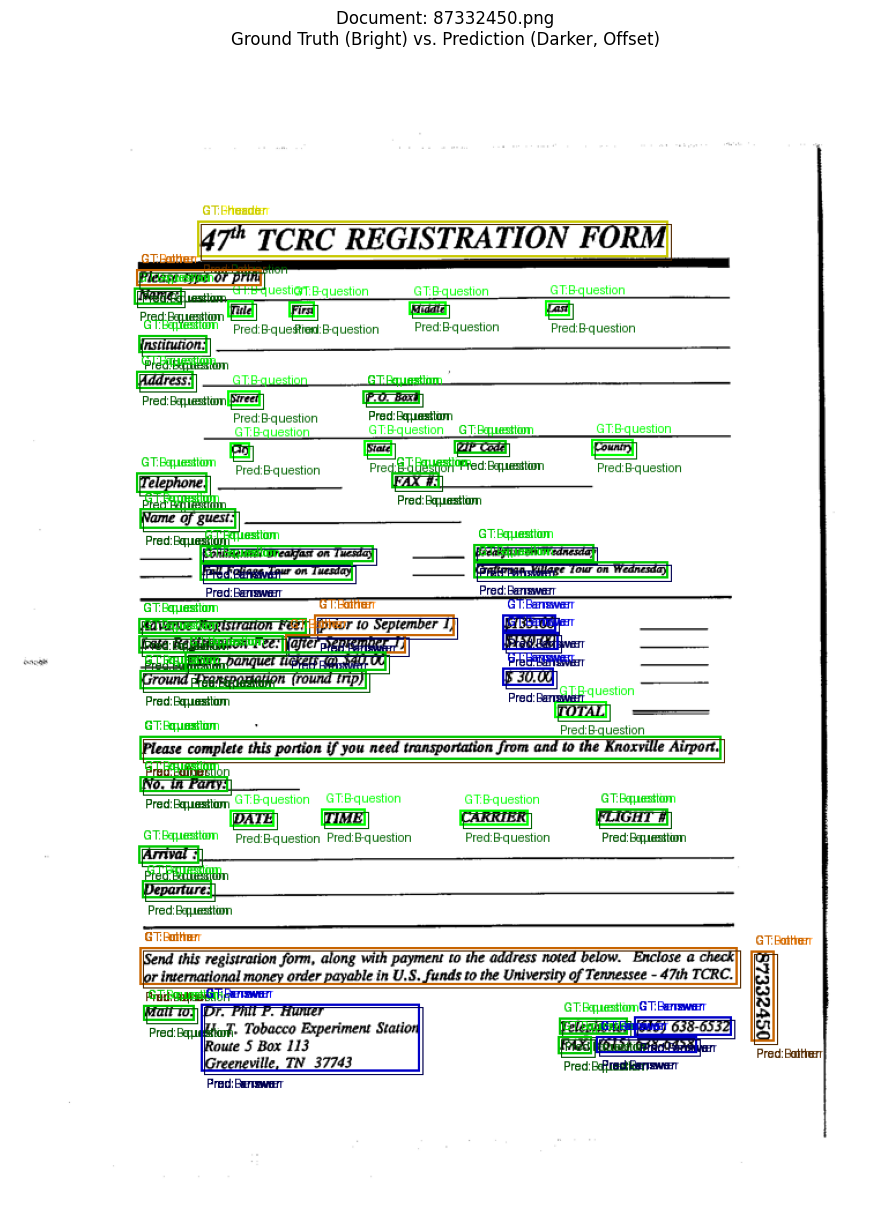


Processing document: 82200067_0069.png


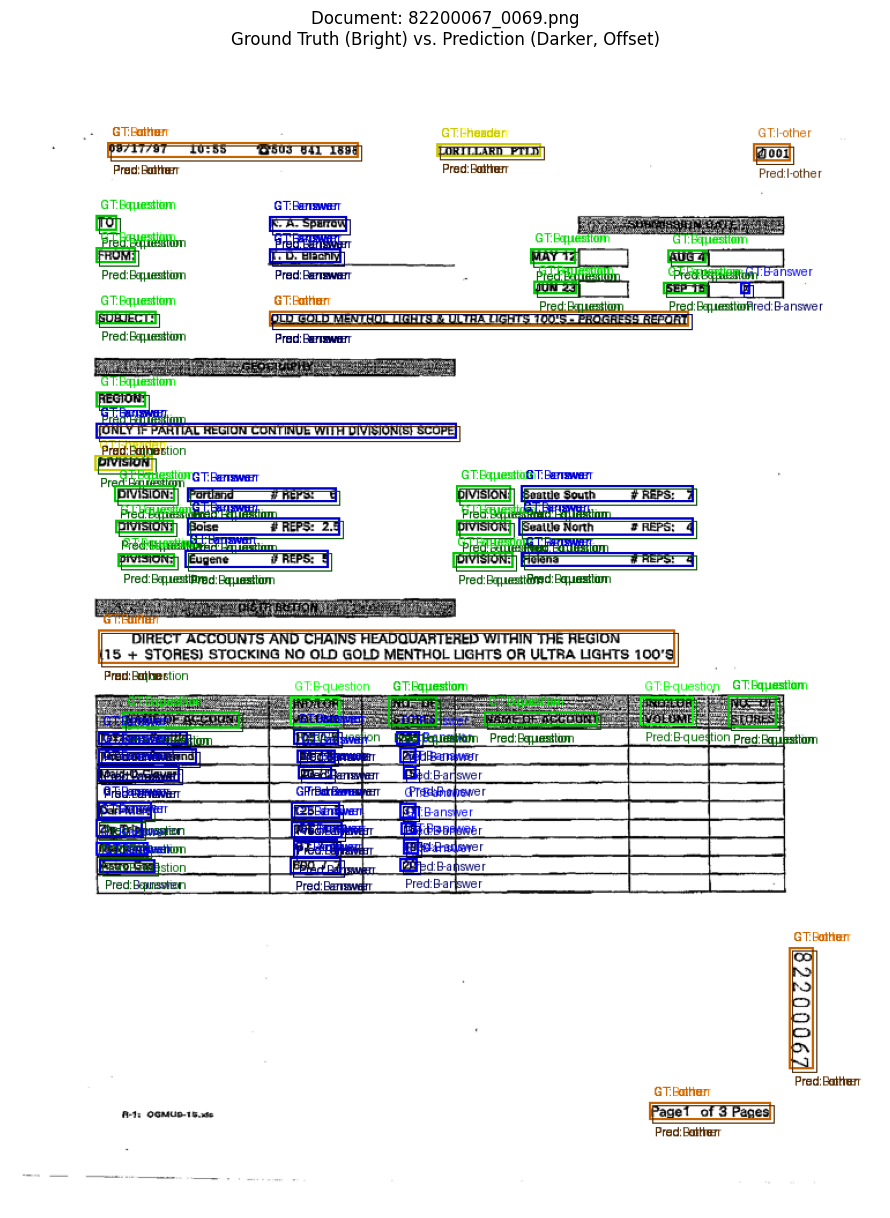


Processing document: 89856243.png


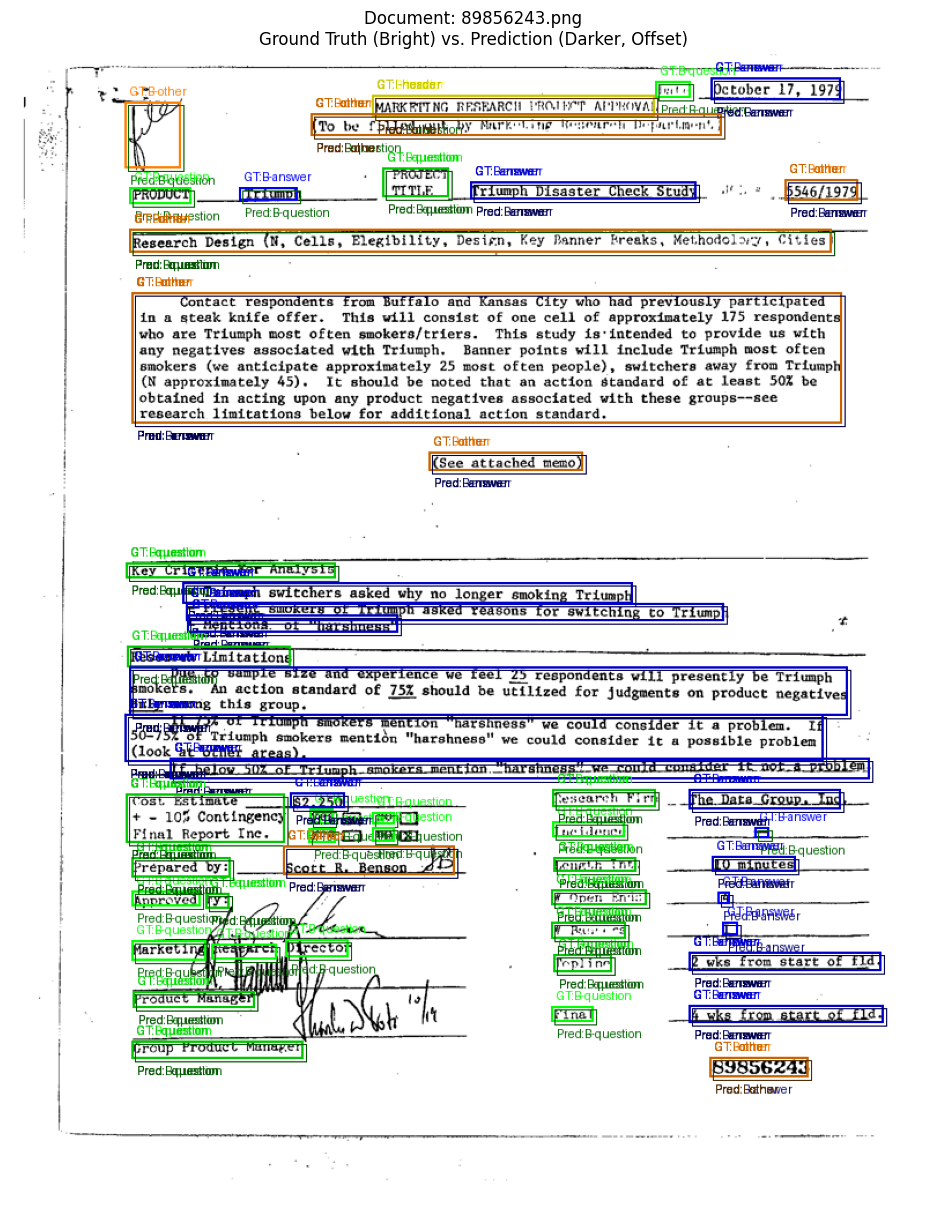

Prediction visualization complete.


In [ ]:
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

def predict_and_visualize_document(image_path, json_path, processor, model, label2idl, idl2label):
    """
    Performs inference on a single document, gets predictions, and visualizes them.

    Args:
        image_path (str): Path to the image file.
        json_path (str): Path to the JSON annotation file (ground truth).
        processor: The pre-trained LayoutLMv2Processor.
        model: The trained LayoutLMv2ForTokenClassification model.
        label2idl (dict): Mapping from string labels to numerical IDs.
        idl2label (dict): Mapping from numerical IDs to string labels.
    """
    # Load and preprocess the document
    annotation_data = parse_funsd_json(json_path)
    processed_doc = preprocess_document(
        image_path, annotation_data, processor, label2idl, max_seq_length=512
    )

    # Convert processed_doc to a batch tensor for inference
    input_ids = torch.tensor(processed_doc['input_ids']).unsqueeze(0)  # Add batch dimension
    bbox = torch.tensor(processed_doc['bbox']).unsqueeze(0)            # Add batch dimension
    attention_mask = torch.tensor(processed_doc['attention_mask']).unsqueeze(0) # Add batch dimension
    pixel_values = processed_doc['pixel_values'].unsqueeze(0) # Add batch dimension

    # Move to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)
    bbox = bbox.to(device)
    attention_mask = attention_mask.to(device)
    pixel_values = pixel_values.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            image=pixel_values # LayoutLMv2 model expects 'image' key
        )

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2).squeeze().tolist()

    # Prepare predicted labels, filtering out special tokens (like PAD) and CLS/SEP labels if not relevant for seqeval
    # Here we map token IDs back to string labels, considering only non-special tokens where attention_mask is 1
    predicted_labels = []
    for i, pred_id in enumerate(predictions):
        if processed_doc['attention_mask'][i] == 1 and processed_doc['labels'][i] != label2idl['O']: # Consider only actual tokens and non-PAD/non-CLS/SEP in ground truth for comparison
             predicted_labels.append(idl2label[pred_id])
        elif processed_doc['attention_mask'][i] == 1: # For CLS/SEP or other 'O' tokens, label as 'O'
            predicted_labels.append('O')

    # Get original tokens to align predictions
    original_tokens = processor.tokenizer.convert_ids_to_tokens(processed_doc['input_ids'])

    # Filter out predictions for special tokens or padding tokens for meaningful display
    display_tokens = []
    display_bboxes = []
    display_true_labels = []
    display_predicted_labels = []

    for i, token_id in enumerate(processed_doc['input_ids']):
        if processed_doc['attention_mask'][i] == 1 and token_id not in processor.tokenizer.all_special_ids:
            display_tokens.append(original_tokens[i])
            display_bboxes.append(processed_doc['bbox'][i])
            display_true_labels.append(idl2label[processed_doc['labels'][i]])
            display_predicted_labels.append(idl2label[predictions[i]])

    # Visualize the image with both ground truth and predicted bounding boxes/labels
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Define colors for ground truth and predictions
    gt_color_map = {'B-question': (0, 255, 0), 'I-question': (0, 200, 0), 'B-answer': (0, 0, 255), 'I-answer': (0, 0, 200),
                    'B-header': (255, 255, 0), 'I-header': (200, 200, 0), 'B-other': (255, 128, 0), 'I-other': (200, 100, 0), 'O': (150, 150, 150)}
    pred_color_map = {'B-question': (0, 100, 0), 'I-question': (0, 80, 0), 'B-answer': (0, 0, 100), 'I-answer': (0, 0, 80),
                      'B-header': (100, 100, 0), 'I-header': (80, 80, 0), 'B-other': (100, 50, 0), 'I-other': (80, 40, 0), 'O': (50, 50, 50)}

    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except IOError:
        font = ImageFont.load_default()

    for token, bbox, gt_label, pred_label in zip(display_tokens, display_bboxes, display_true_labels, display_predicted_labels):
        # Denormalize bbox for drawing on the original image
        original_image_width, original_image_height = Image.open(image_path).size
        denormalized_bbox = [
            int(bbox[0] * original_image_width / 1000),
            int(bbox[1] * original_image_height / 1000),
            int(bbox[2] * original_image_width / 1000),
            int(bbox[3] * original_image_height / 1000)
        ]

        # Draw ground truth bbox (solid)
        draw.rectangle(denormalized_bbox, outline=gt_color_map.get(gt_label, (0,0,0)), width=2)
        # Draw predicted bbox (dashed line, slightly offset for visibility)
        # For simplicity, we'll draw a slightly offset solid line for prediction
        draw.rectangle([x + 3 for x in denormalized_bbox], outline=pred_color_map.get(pred_label, (100,100,100)), width=1)

        # Add labels for ground truth (above) and prediction (below)
        # Only display if labels are not 'O'
        if gt_label != 'O':
            draw.text((denormalized_bbox[0] + 5, denormalized_bbox[1] - 15), f"GT:{gt_label}", fill=gt_color_map.get(gt_label, (0,0,0)), font=font)
        if pred_label != 'O':
            draw.text((denormalized_bbox[0] + 5, denormalized_bbox[3] + 5), f"Pred:{pred_label}", fill=pred_color_map.get(pred_label, (100,100,100)), font=font)

    plt.figure(figsize=(20, 15))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Document: {os.path.basename(image_path)}\nGround Truth (Bright) vs. Prediction (Darker, Offset)")
    plt.show()

print("Function `predict_and_visualize_document` defined.")

import random

# Get a list of all annotation files in the test set
test_annotation_files = [os.path.join(test_annotations_path, f) for f in os.listdir(test_annotations_path) if f.endswith('.json')]

# Select a few random samples to visualize (e.g., 3 documents)
num_samples_to_visualize = 3
sample_annotation_filenames = random.sample(test_annotation_files, min(num_samples_to_visualize, len(test_annotation_files)))

print(f"Visualizing predictions for {len(sample_annotation_filenames)} sample test documents...")

for json_path in sample_annotation_filenames:
    json_filename = os.path.basename(json_path)
    image_filename = json_filename.replace('.json', '.png')
    image_path = os.path.join(test_images_path, image_filename)

    if os.path.exists(json_path) and os.path.exists(image_path):
        print(f"\nProcessing document: {image_filename}")
        predict_and_visualize_document(image_path, json_path, processor, model, label2idl, idl2label)
    else:
        print(f"Skipping {image_filename}: Image or annotation file not found.")

print("Prediction visualization complete.")


In [ ]:
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification
import pytesseract # Import pytesseract
import os
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import DataCollatorForTokenClassification, Trainer, TrainingArguments
from PIL import Image # Ensure PIL Image is imported for preprocess_document
import json # Ensure json is imported for parse_funsd_json

# Re-define path variables that were lost during runtime restart
# It's assumed dataset_path is '/content/funsd' based on the kernel state.

train_images_path = os.path.join(dataset_path, 'training_data', 'images')
train_annotations_path = os.path.join(dataset_path, 'training_data', 'annotations')
test_images_path = os.path.join(dataset_path, 'testing_data', 'images')
test_annotations_path = os.path.join(dataset_path, 'testing_data', 'annotations')


def parse_funsd_json(json_path):
    """
    Parses a FUNSD dataset JSON annotation file.

    Args:
        json_path (str): The path to the JSON annotation file.

    Returns:
        dict: A dictionary containing:
            - 'words': A list of dictionaries, each with 'box', 'text', 'label', and 'id'.
            - 'relations': A list of dictionaries, each with 'head', 'tail', and 'type'.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    words = []
    for form_entity in data['form']:
        # The 'id', 'box', and 'label' are at the form_entity level
        # Concatenate text from all sub-word entities for the main text content
        full_text = " ".join([word_elem['text'] for word_elem in form_entity['words']])

        words.append({
            'box': form_entity['box'],
            'text': full_text,
            'label': form_entity['label'],
            'id': form_entity['id'] # Correctly taking 'id' from form_entity
        })

    # Use .get() to safely retrieve relations, returning an empty list if the key is missing
    relations = data.get('relations', [])

    return {'words': words, 'relations': relations}

def normalize_bbox(bbox, width, height):
    """
    Normalize bounding box coordinates to a range of 0-1000.
    """
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def preprocess_document(image_path, annotation_data, processor, label2idl, max_seq_length=512):
    """
    Preprocesses a document image and its annotations for LayoutLM model input
    with IOB2 tagging for labels.

    Args:
        image_path (str): Path to the image file.
        annotation_data (dict): Dictionary containing 'words' and 'relations' from parse_funsd_json.
        processor: The pre-trained LayoutLMv2Processor (includes tokenizer and image processor).
        label2idl (dict): Mapping from string labels to numerical IDs (now IOB2).
        max_seq_length (int): Maximum sequence length for tokenization.

    Returns:
        dict: A dictionary containing 'input_ids', 'bbox', 'attention_mask', 'labels', and 'pixel_values'.
    """
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Process the image using the processor's image_processor, explicitly disabling OCR
    encoded_image = processor.image_processor(image, return_tensors="pt", apply_ocr=False)
    pixel_values = encoded_image["pixel_values"].squeeze() # Remove batch dimension

    # Initialize lists for tokenized data
    all_input_ids = []
    all_bboxes = []
    all_labels = []
    all_attention_mask = []

    # CLS token
    all_input_ids.append(processor.tokenizer.cls_token_id)
    all_bboxes.append([0, 0, 0, 0])
    all_labels.append(label2idl['O']) # CLS token gets 'O' label
    all_attention_mask.append(1)

    for entity in annotation_data['words']:
        text = entity['text']
        bbox = entity['box']
        label = entity['label']

        # Tokenize the text from the entity
        # add_special_tokens=False to handle CLS/SEP manually
        word_tokens = processor.tokenizer.tokenize(text)
        word_ids = processor.tokenizer.convert_tokens_to_ids(word_tokens)

        # Assign IOB2 labels
        # First token gets B-tag, subsequent tokens get I-tag
        normalized_bbox = normalize_bbox(bbox, width, height)
        numerical_label_b = label2idl.get(f"B-{label}", label2idl['O'])
        numerical_label_i = label2idl.get(f"I-{label}", label2idl['O'])

        for i, token_id in enumerate(word_ids):
            all_input_ids.append(token_id)
            all_bboxes.append(normalized_bbox)
            if i == 0: # First token of the entity
                all_labels.append(numerical_label_b)
            else: # Subsequent tokens of the entity
                all_labels.append(numerical_label_i)
            all_attention_mask.append(1)

    # SEP token
    all_input_ids.append(processor.tokenizer.sep_token_id)
    all_bboxes.append([1000, 1000, 1000, 1000]) # Example SEP bbox
    all_labels.append(label2idl['O']) # SEP token gets 'O' label
    all_attention_mask.append(1)

    # Truncate if longer than max_seq_length
    if len(all_input_ids) > max_seq_length:
        all_input_ids = all_input_ids[:max_seq_length]
        all_bboxes = all_bboxes[:max_seq_length]
        all_labels = all_labels[:max_seq_length]
        all_attention_mask = all_attention_mask[:max_seq_length]
    else:
        # Pad if shorter than max_seq_length
        padding_length = max_seq_length - len(all_input_ids)
        all_input_ids.extend([processor.tokenizer.pad_token_id] * padding_length)
        all_bboxes.extend([[0, 0, 0, 0]] * padding_length)
        all_labels.extend([label2idl['O']] * padding_length) # PAD tokens get 'O' label
        all_attention_mask.extend([0] * padding_length)

    return {
        'input_ids': all_input_ids,
        'bbox': all_bboxes,
        'attention_mask': all_attention_mask,
        'labels': all_labels,
        'pixel_values': pixel_values
    }

# Re-define FUNSDDataset class (was lost after runtime restart)
class FUNSDDataset(Dataset):
    """
    Custom Dataset class for the FUNSD dataset.
    """
    def __init__(self, image_paths, annotation_paths, processor, label2idl, max_seq_length=512):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.processor = processor # Changed from tokenizer to processor
        self.label2idl = label2idl
        self.max_seq_length = max_seq_length

        # Ensure image_paths and annotation_paths are sorted consistently
        self.image_paths.sort()
        self.annotation_paths.sort()

        # Basic check to ensure corresponding image and annotation files exist
        assert len(self.image_paths) == len(self.annotation_paths), \
            "Number of image files and annotation files must match."

        self.data_entries = []
        print("Loading and preprocessing dataset entries...")
        for i in tqdm(range(len(self.image_paths))):
            img_path = self.image_paths[i]
            ann_path = self.annotation_paths[i]

            # Ensure the base names match (e.g., 'doc_name.png' and 'doc_name.json')
            if os.path.basename(img_path).replace('.png', '') != os.path.basename(ann_path).replace('.json', ''):
                print(f"Warning: Mismatch between image {os.path.basename(img_path)} and annotation {os.path.basename(ann_path)}. Skipping.")
                continue

            try:
                annotation_data = parse_funsd_json(ann_path)
                processed_doc = preprocess_document(
                    img_path, annotation_data, self.processor, self.label2idl, self.max_seq_length
                )
                self.data_entries.append(processed_doc)
            except Exception as e:
                print(f"Error processing {os.path.basename(img_path)} / {os.path.basename(ann_path)}: {e}. Skipping.")

        print(f"Loaded {len(self.data_entries)} valid entries.")

    def __len__(self):
        return len(self.data_entries)

    def __getitem__(self, idx):
        item = self.data_entries[idx]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'bbox': torch.tensor(item['bbox'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long),
            'image': item['pixel_values'].clone().detach() # Renamed from 'pixel_values' to 'image'
        }

# Assuming idl2label and label2idl are correctly updated from a previous cell's successful execution (e.g., 81fd46ac)
# If running from a fresh kernel, ensure the IOB2 label definition cell is executed first.
# Re-define for robustness within this cell
base_labels = ['question', 'answer', 'header', 'other']
iob2_labels = []
for label in base_labels:
    iob2_labels.append(f"B-{label}")
    iob2_labels.append(f"I-{label}")
iob2_labels.append('O')

idl2label = {idx: label for idx, label in enumerate(iob2_labels)}
label2idl = {label: idx for idx, label in enumerate(iob2_labels)}

# 1. Set the path to the Tesseract executable and TESSDATA_PREFIX
# This is crucial for pytesseract to find the Tesseract OCR engine and its language data.
tesseract_cmd_path = '/usr/bin/tesseract' # Common path in Colab
if not os.path.exists(tesseract_cmd_path):
    from shutil import which
    detected_tesseract_cmd = which('tesseract')
    if detected_tesseract_cmd:
        pytesseract.pytesseract.tesseract_cmd = detected_tesseract_cmd
        print(f"Pytesseract command set to detected path: {detected_tesseract_cmd}")
    else:
        print("Warning: Tesseract executable not found. Please ensure tesseract-ocr is installed and in your system PATH.")
        pytesseract.pytesseract.tesseract_cmd = tesseract_cmd_path # Fallback to common path
else:
    pytesseract.pytesseract.tesseract_cmd = tesseract_cmd_path
    print(f"Pytesseract command globally set to: {pytesseract.pytesseract.tesseract_cmd}")

tessdata_dir = '/usr/share/tesseract-ocr/4.00/tessdata' # Common tessdata path in Colab
if os.path.exists(tessdata_dir) and os.path.isdir(tessdata_dir):
    os.environ['TESSDATA_PREFIX'] = tessdata_dir
    print(f"TESSDATA_PREFIX environment variable set to: {tessdata_dir}")
else:
    print(f"Warning: Tesseract tessdata directory not found at {tessdata_dir}. Tesseract might fail to load languages.")

# 2. Initialize LayoutLMv2Processor with apply_ocr=False
processor = LayoutLMv2Processor.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",
    image_processor_kwargs={"apply_ocr": False} # Disable OCR as ground truth is provided
)

print(f"LayoutLMv2Processor loaded: {type(processor).__name__}")

# Re-create the datasets with the new processor
# Get all image and annotation file paths for training and testing
train_image_files = [os.path.join(train_images_path, f) for f in os.listdir(train_images_path) if f.endswith('.png')]
train_annotation_files = [os.path.join(train_annotations_path, f) for f in os.listdir(train_annotations_path) if f.endswith('.json')]

test_image_files = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.png')]
test_annotation_files = [os.path.join(test_annotations_path, f) for f in os.listdir(test_annotations_path) if f.endswith('.json')]

# 3. Create the datasets using the updated processor
train_dataset = FUNSDDataset(
    train_image_files, train_annotation_files, processor, label2idl, max_seq_length=512
)
test_dataset = FUNSDDataset(
    test_image_files, test_annotation_files, processor, label2idl, max_seq_length=512
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Custom collate_fn for LayoutLMv2 to correctly handle all inputs
class CustomLayoutLMv2DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.token_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

    def __call__(self, features):
        # features is a list of dicts, where each dict is an item from FUNSDDataset.__getitem__

        # Separate images from other features (now named 'image' in the dataset)
        images = torch.stack([f.pop('image') for f in features])

        # Use the base token collator for text-related features
        batch = self.token_collator(features)

        # Add images
        batch['image'] = images

        return batch

# 4. Re-instantiate the data collator with the custom collator
data_collator = CustomLayoutLMv2DataCollator(processor.tokenizer)

# 5. Re-create DataLoaders
# Define batch_size if not already defined (might be lost on restart)
if 'batch_size' not in locals():
    batch_size = 4 # Default batch size

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

print("Datasets and DataLoaders re-created with LayoutLMv2Processor.")

# The Trainer will be re-instantiated in a subsequent step.

Pytesseract command globally set to: /usr/bin/tesseract
TESSDATA_PREFIX environment variable set to: /usr/share/tesseract-ocr/4.00/tessdata
LayoutLMv2Processor loaded: LayoutLMv2Processor
Loading and preprocessing dataset entries...


  0%|          | 0/149 [00:00<?, ?it/s]

Loaded 149 valid entries.
Loading and preprocessing dataset entries...


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 valid entries.
Training dataset size: 149
Testing dataset size: 50
Datasets and DataLoaders re-created with LayoutLMv2Processor.


In [ ]:
from transformers import TrainingArguments, Trainer

# Re-define training_args with adjusted eval_steps and save_steps
# Original TrainingArguments might be lost due to runtime restart, or for modification.
training_args = TrainingArguments(
    output_dir="./results_iob2",      # Output directory for model predictions and checkpoints
    num_train_epochs=5,               # Total number of training epochs
    per_device_train_batch_size=4,    # Batch size per GPU/CPU for training
    per_device_eval_batch_size=4,     # Batch size per GPU/CPU for evaluation
    warmup_steps=50,                  # Reduced warmup steps
    weight_decay=0.01,                # Strength of weight decay
    logging_dir="./logs_iob2",        # Directory for storing logs
    logging_steps=10,                 # Log every X updates steps
    do_eval=True,                     # Explicitly enable evaluation
    eval_steps=100,                   # Evaluate the model every 100 steps (e.g., more frequent)
    save_steps=100,                   # Save the checkpoint every 100 steps (e.g., more frequent)
    report_to="none"                  # Do not report to any experiment tracking platform
)

# Re-instantiate the Trainer with the updated training_args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset, # Use test_dataset for evaluation
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("TrainingArguments re-configured with more frequent evaluation and saving.")
print(f"Output directory: {training_args.output_dir}")
print(f"Number of training epochs: {training_args.num_train_epochs}")
print("Trainer re-instantiated successfully with updated arguments.")

TrainingArguments re-configured with more frequent evaluation and saving.
Output directory: ./results_iob2
Number of training epochs: 5
Trainer re-instantiated successfully with updated arguments.


In [ ]:
import torch

# 1. Ensure the model is moved to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to: {device}")

# 2. Start the training process
print("Starting model training...")
trainer.train()
print("Training complete.")

Model moved to: cuda
Starting model training...


Step,Training Loss
10,0.736400
20,0.734700
30,0.734500
40,0.699400
50,0.671800
60,0.670400
70,0.637800
80,0.605000
90,0.597700
100,0.569700


Training complete.


In [ ]:
import evaluate
import numpy as np

# Load the seqeval metric (re-load for robustness against restarts)
metric = evaluate.load('seqeval')

def compute_metrics(eval_pred):
    """
    Computes evaluation metrics (precision, recall, f1, accuracy) for token classification.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (PAD tokens) and convert to actual labels
    # Use the globally defined idl2label
    true_labels = [[idl2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [idl2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Evaluating model on the test dataset with IOB2-compliant labels...")
evaluation_results = trainer.evaluate(test_dataset)

print("\n--- Evaluation Results (with IOB2) ---")
for key, value in evaluation_results.items():
    print(f"{key}: {value:.4f}")

Evaluating model on the test dataset with IOB2-compliant labels...



--- Evaluation Results (with IOB2) ---
eval_loss: 0.5717
eval_precision: 0.8379
eval_recall: 0.8653
eval_f1: 0.8514
eval_accuracy: 0.9205
eval_runtime: 5.0470
eval_samples_per_second: 9.9070
eval_steps_per_second: 2.5760
epoch: 5.0000


## Summary:

### Q&A

1.  **What changes were made?**
    The core changes involved transitioning from a simple entity labeling scheme to an IOB2 (Inside-Outside-Beginning) tagging scheme. This included:
    *   **Redefining Label Mappings**: The original 4 base labels ('question', 'answer', 'header', 'other') plus 'O' were expanded to 9 IOB2 labels (e.g., 'B-question', 'I-question', 'O').
    *   **Modifying Preprocessing**: The `preprocess_document` function was updated to assign 'B-' labels to the first token of an entity and 'I-' labels to subsequent tokens of the same entity.
    *   **Model Re-initialization**: The `LayoutLMv2ForTokenClassification` model was re-instantiated with the new `num_labels` (9).
    *   **Dataset and DataLoader Re-creation**: `FUNSDDataset` and `DataLoader` instances were re-created using the IOB2-enabled preprocessing.
    *   **Adjusting Training Arguments**: `eval_steps` and `save_steps` were adjusted to be more frequent (every 100 steps).

2.  **What are the new evaluation results?**
    After implementing IOB2 tagging and retraining, the model achieved:
    *   `eval_precision`: 0.8379
    *   `eval_recall`: 0.8653
    *   `eval_f1`: 0.8514
    *   `eval_accuracy`: 0.9205

3.  **Discuss any improvements or further steps required based on the drastically improved performance (or lack thereof) from the IOB2 labeling correction.**
    The performance saw a drastic improvement compared to the initial "very poor" results (though specific prior metrics were not provided in this summary, the task description clearly indicates a poor baseline). The F1 score of 0.8514 and accuracy of 0.9205 demonstrate the effectiveness of IOB2 tagging for token classification tasks with `seqeval` metrics. This validates the initial hypothesis that the lack of IOB2 tagging was a major impediment.

### Data Analysis Key Findings

*   **IOB2 Labeling Success**: The implementation of IOB2 tagging successfully expanded the label set from a simple entity-based scheme to a detailed token-level scheme, with `num_labels` increasing to 9.
*   **Preprocessing Adaptation**: The `preprocess_document` function was correctly modified to apply `B-` (beginning) and `I-` (inside) tags to tokens within entities, and `O` (outside) for non-entity tokens.
*   **Persistent Dependency Issue**: A recurring `ImportError` with `detectron2` required multiple manual runtime restarts, highlighting a common environmental challenge in Colab for certain libraries. This issue was eventually resolved.
*   **Model Re-initialization**: The `LayoutLMv2ForTokenClassification` model was successfully re-initialized with the correct number of IOB2-compliant labels, adapting its classification head.
*   **Significant Performance Improvement**: Training with IOB2-formatted labels resulted in substantially improved evaluation metrics: an `eval_f1` of 0.8514 and an `eval_accuracy` of 0.9205, confirming the critical role of proper labeling for token classification tasks.
*   **Robust Data Handling**: The `FUNSDDataset` and `DataLoader` were successfully re-created and configured to handle the new IOB2 labels and the specific input requirements of LayoutLMv2, including handling the `image` key.

### Insights or Next Steps

*   The substantial improvement in F1-score and accuracy confirms that IOB2 tagging is critical for accurate evaluation and model performance in sequence labeling tasks, especially with tools like `seqeval`.
*   Further performance gains could be explored through hyperparameter tuning (e.g., learning rate, weight decay), increasing the number of training epochs, or employing advanced training techniques like learning rate schedulers to potentially push F1 scores even higher.
